In [43]:
!pip install Sastrawi

In [44]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [45]:
df = pd.read_excel('data_label.xlsx')
df = df[['data']]
print(df.head())

                                                data
0                       semakin kekini semakin payah
1                                        update mulu
2  aplikasi ini pengiriman lambataturan di membua...
3                                               baik
4  suka error buka aplikasi terlalu berat di awal...


In [46]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

try:
    stop_word = set(stopwords.words('indonesian'))
except:
    stop_word = set([
        "ada", "yang", "bahwa", "dan", "untuk", "oleh",
        "dalam", "antar", "pada", "menjadi", "lebih",
        "beberapa", "sebagian", "banyak", "hanya",
        "juga", "namun", "di"
    ])

normalisasi = {
    "aaya": "saya",
    "sy": "saya",
    "gw": "saya",
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "tdk": "tidak",
    "akun": "akun",
    "account": "akun",

}

def preprocessing(content):
    content = re.sub(r'[^a-zA-Z\s]', ' ', str(content).lower())
    tokens = content.split()
    tokens = [normalisasi.get(token, token) for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop_word]
    stemmed = [stemmer.stem(token) for token in filtered_tokens]
    return ' '.join(stemmed)

df['stemmed'] = df['data'].apply(preprocessing)
df[['stemmed']].to_csv('hasil_preprocessing.csv', index=False)

In [47]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['stemmed'])

df_tfidf = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
df_tfidf.head(5).iloc[:, :5]

,ada,adastatusa,admin,adu,agar
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [57]:
df[['data', 'cluster']].head()

,data,cluster
0,semakin kekini semakin payah,2
1,update mulu,2
2,aplikasi ini pengiriman lambataturan di membua...,2
3,baik,5
4,suka error buka aplikasi terlalu berat di awal...,2


In [48]:
range_n_clusters = range(2, 8)
scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    scores.append(silhouette_score(X, kmeans.labels_))

In [49]:
best_k = list(range_n_clusters)[np.argmax(scores)]
print(f'K optimal berdasarkan Silhouette Score: {best_k}')

K optimal berdasarkan Silhouette Score: 7


In [50]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

In [51]:
kmeans= KMeans(n_clusters=best_k, random_state=42,n_init=10)
kmeans.fit(X)

KMeans(n_clusters=7, n_init=10, random_state=42)

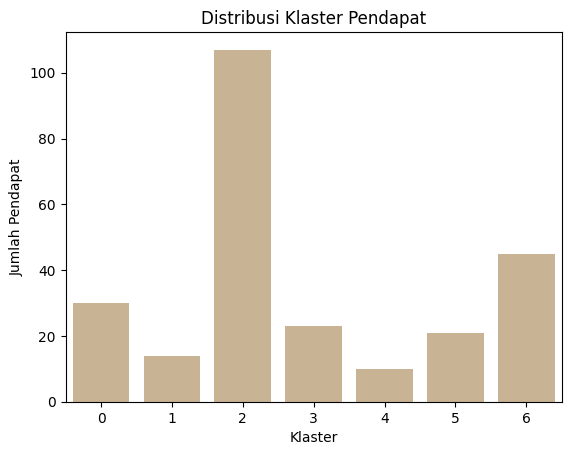

In [52]:
sns.countplot(x='cluster', data=df, color='tan')
plt.title('Distribusi Klaster Pendapat')
plt.xlabel('Klaster')
plt.ylabel('Jumlah Pendapat')
plt.show()

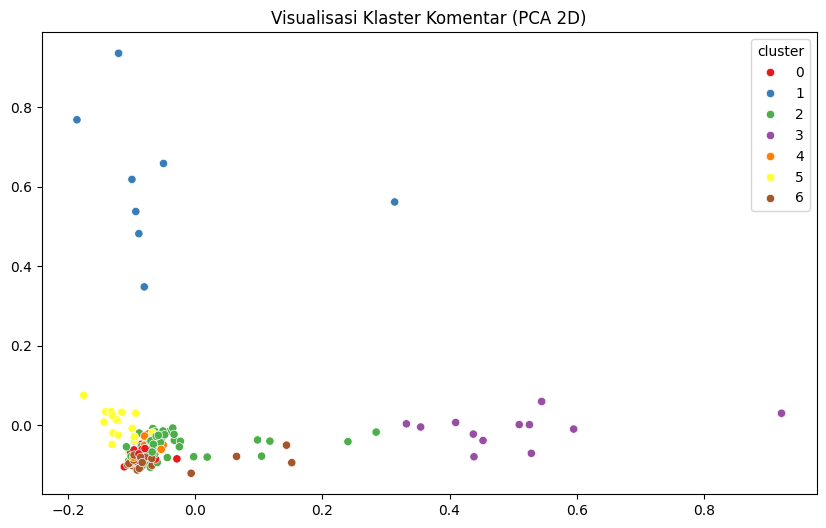

In [53]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())
plt.figure(figsize=(10,6))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=df['cluster'], palette='Set1')
plt.title('Visualisasi Klaster Komentar (PCA 2D)')
plt.show()

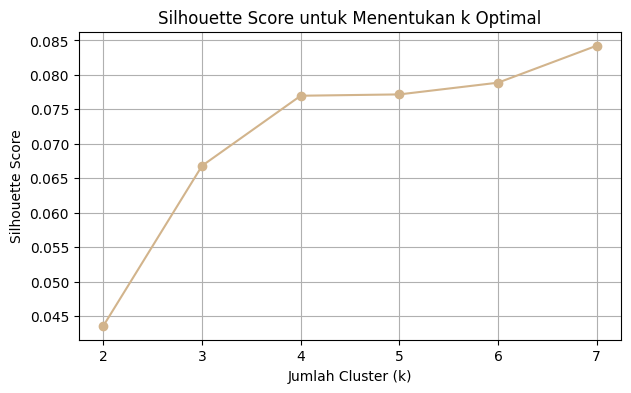

In [54]:
plt.figure(figsize=(7,4))
plt.plot(range_n_clusters, scores, marker='o', color='tan')
plt.title('Silhouette Score untuk Menentukan k Optimal')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [55]:
final_score = silhouette_score(X, df['cluster'])
print(f'Silhouette Score (k={best_k}): {final_score:.4f}')

Silhouette Score (k=7): 0.0842


Inertia (WCSS) per k:
    k  wcss_inertia
0   1    241.225312
1   2    229.120626
2   3    220.483559
3   4    213.860621
4   5    211.295750
5   6    208.446836
6   7    204.755313
7   8    201.893741
8   9    199.401024
9  10    198.187471


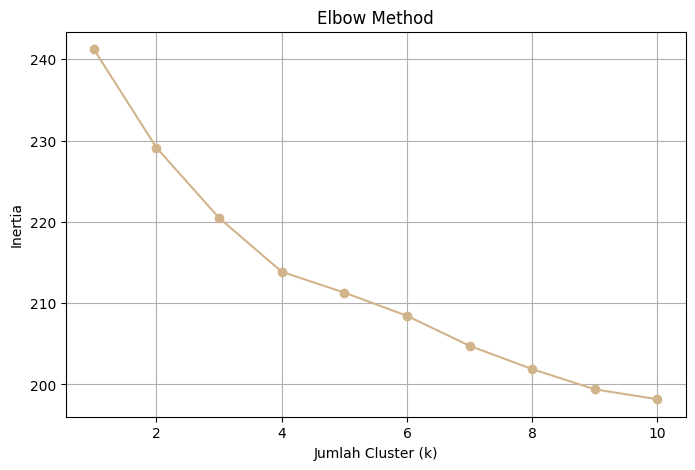

Optimal k = 4
Inertia pada k optimal = 213.86062079722174


In [56]:
inertia_values = []
K = range(1, 11)

# Menghitung inertia untuk k = 1 sampai 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Menentukan garis dari titik pertama ke titik terakhir
x1, y1 = 1, inertia_values[0]
x2, y2 = K[-1], inertia_values[-1]

distances = []
for k, inertia in zip(K, inertia_values):
    # Menghitung jarak tiap titik inertia ke garis
    distance = abs((y2 - y1)*k - (x2 - x1)*inertia + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(distance)

# Menentukan k dengan jarak terbesar (elbow)
optimal_k = K[np.argmax(distances)]
optimal_inertia = inertia_values[optimal_k - 1]

# Tampilkan tabel hasil
hasil = pd.DataFrame({'k': list(K), 'wcss_inertia': inertia_values})
print("Inertia (WCSS) per k:")
print(hasil)

plt.figure(figsize=(8,5))
plt.plot(K, inertia_values, marker='o', color='tan')
plt.title("Elbow Method")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()
print("Optimal k =", optimal_k)
print("Inertia pada k optimal =", optimal_inertia)
